# Este projeto também está disponível localmente e no GITHUB

## Diretório do projeto e link do GITHUB

- 'C:/Users/miche/Desktop/CAPSTONE/insper0924'
- [Capstone_Outlier_Fcst](https://github.com/mconjaud/Capstone.git)



### Bibliotecas utilizadas


In [25]:
#Instalações necessárias
#!pip install sktime

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import linregress
from numpy.polynomial.polynomial import Polynomial
from prophet import Prophet
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    TBATS,
    StatsForecastAutoARIMA
)
from darts import TimeSeries
import sktime as sk
import os


In [27]:
#Dentro do dataset ALGA28 criar novo db em que os registros de DataReferencia sejam apenas de 2023 e 2024
#Carregar o dataset
df = pd.read_csv('ALGA28.csv')
df = df[df['dataReferencia'] > '2023-01-01']
print(df.count())
# Guardar o banco de dados em um arquivo csv do codigo ALGA28
df.to_csv('C:/Users/miche/Desktop/CAPSTONE/Capstone/ALGA28_2324.csv', index=False)



Unnamed: 0             440
id                     440
dataReferencia         440
codigo                 440
nome                   440
repacVenc              440
indice                 440
correcao               440
taxaCompra             440
taxaVenda              440
taxaIndicativa         440
desvioPadrao           440
intervaloMin           440
intervaloMax           440
pu                     440
percPu                 440
duration               440
percReune              440
referenciaNTNB         440
spread_bid_ask         440
spread                 440
spread_2               440
taxaIndicativa_diff    440
dtype: int64


## Carregar o dataset e fazer conversões


In [28]:
# Carregar o dataset
ALGA28_2324 = pd.read_csv('C:/Users/miche/Desktop/CAPSTONE/Capstone/ALGA28_2324.csv')
df = ALGA28_2324
# Converter a coluna de data para datetime
df['dataReferencia'] = pd.to_datetime(df['dataReferencia'], errors='coerce')
# Remover valores nulos e selecionar a variável de interesse
df_valid = df[['dataReferencia', 'taxaIndicativa']].dropna()

# Decomposição de série temporal

## 1 - Remoção da tendência

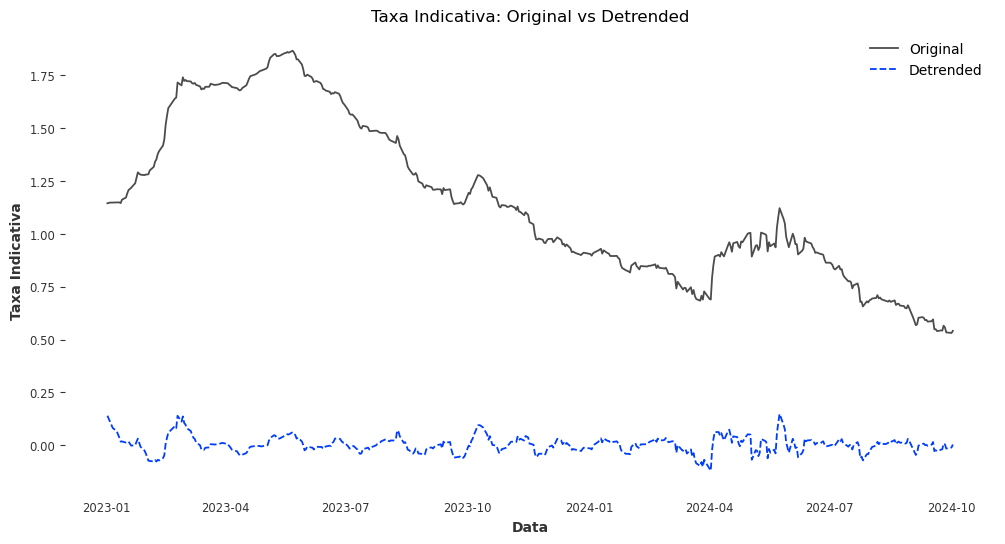

In [29]:
# Decomposição de série temporal e remoção da tendência
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['taxaIndicativa'], model='additive', period=30, extrapolate_trend='freq')
df['taxaIndicativa_detrended'] = df['taxaIndicativa'] - result.trend

# Plotar a série temporal original e a série temporal sem a tendência
plt.figure(figsize=(12, 6))
plt.plot(df['dataReferencia'], df['taxaIndicativa'], label='Original', alpha=0.7)
plt.plot(df['dataReferencia'], df['taxaIndicativa_detrended'], label='Detrended', linestyle='--')
plt.title('Taxa Indicativa: Original vs Detrended')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()

## 2- Remover a sazonalidade 

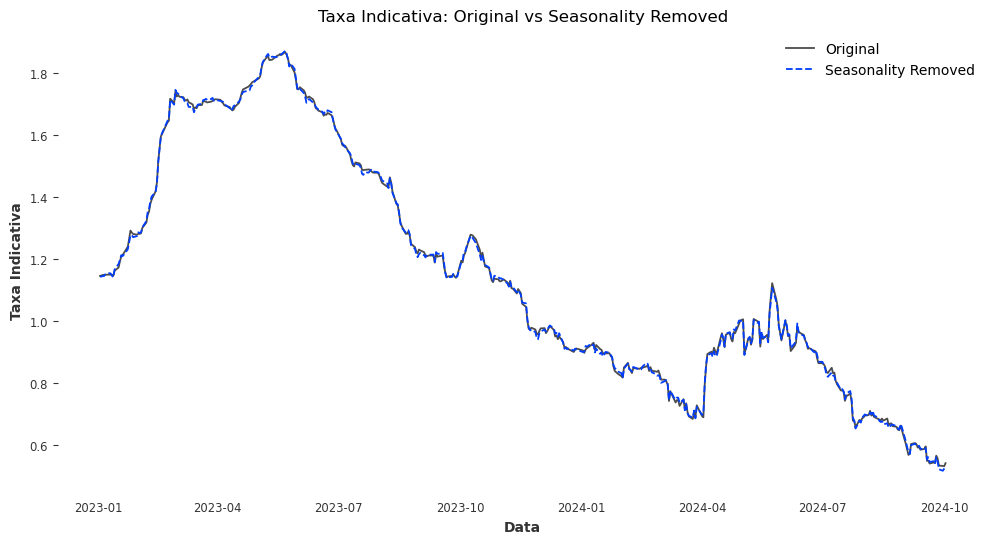

In [30]:
# Decomposição completa para a série original "taxaIndicativa"
result_full = seasonal_decompose(df['taxaIndicativa'], model='additive', period=30, extrapolate_trend='freq')

# Remover apenas a sazonalidade sem remover a tendência
df['taxaIndicativa_no_season'] = df['taxaIndicativa'] - result_full.seasonal

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df['dataReferencia'], df['taxaIndicativa'], label='Original', alpha=0.7)
plt.plot(df['dataReferencia'], df['taxaIndicativa_no_season'], label='Seasonality Removed', linestyle='--')
plt.title('Taxa Indicativa: Original vs Seasonality Removed')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


## 3- Remover a autocorrelação utilizando o ARIMA

c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


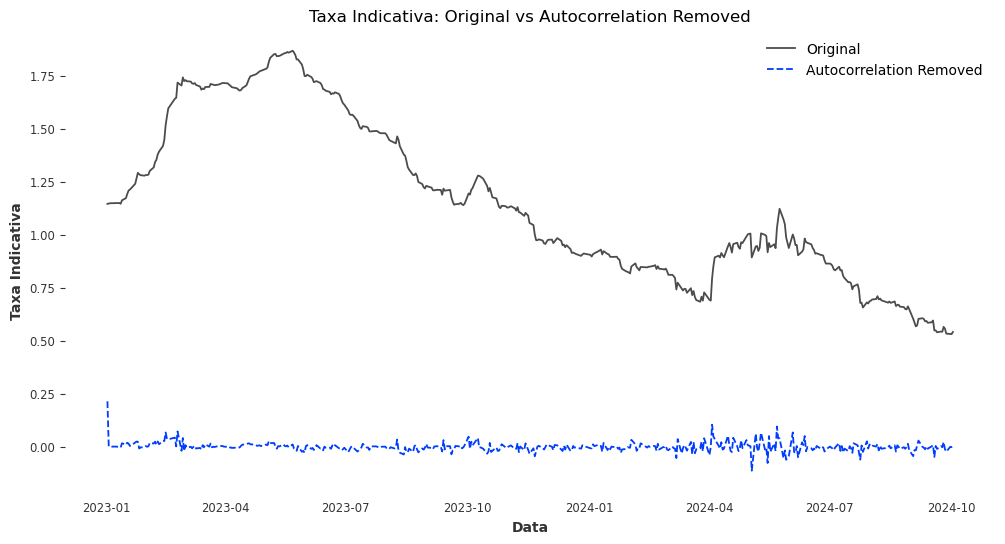

In [31]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustar um modelo ARIMA para capturar autocorrelação
model = ARIMA(df['taxaIndicativa'].dropna(), order=(1, 0, 1))  # Modelo ARMA(1,1)
model_fit = model.fit()

# Obter os resíduos (valores sem autocorrelação)
df['taxaIndicativa_no_autocorr'] = model_fit.resid

# Plotar a série original e os resíduos sem autocorrelação
plt.figure(figsize=(12, 6))
plt.plot(df['dataReferencia'], df['taxaIndicativa'], label='Original', alpha=0.7)
plt.plot(df['dataReferencia'], df['taxaIndicativa_no_autocorr'], label='Autocorrelation Removed', linestyle='--')
plt.title('Taxa Indicativa: Original vs Autocorrelation Removed')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


In [32]:
# ============================================
# Teste ADF para verificar a estacionaridade
# ============================================
adf_result = adfuller(df_valid['taxaIndicativa'])
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

print("Teste Dickey-Fuller Aumentado (ADF) na série original:")
print(f"ADF Estatística: {adf_statistic}")
print(f"p-valor: {p_value}")
print("Valores críticos:", critical_values)
if p_value < 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")


Teste Dickey-Fuller Aumentado (ADF) na série original:
ADF Estatística: -0.43219065527561873
p-valor: 0.9045837673738414
Valores críticos: {'1%': -3.445613745346461, '5%': -2.868269325317112, '10%': -2.5703544951308404}
A série não é estacionária.


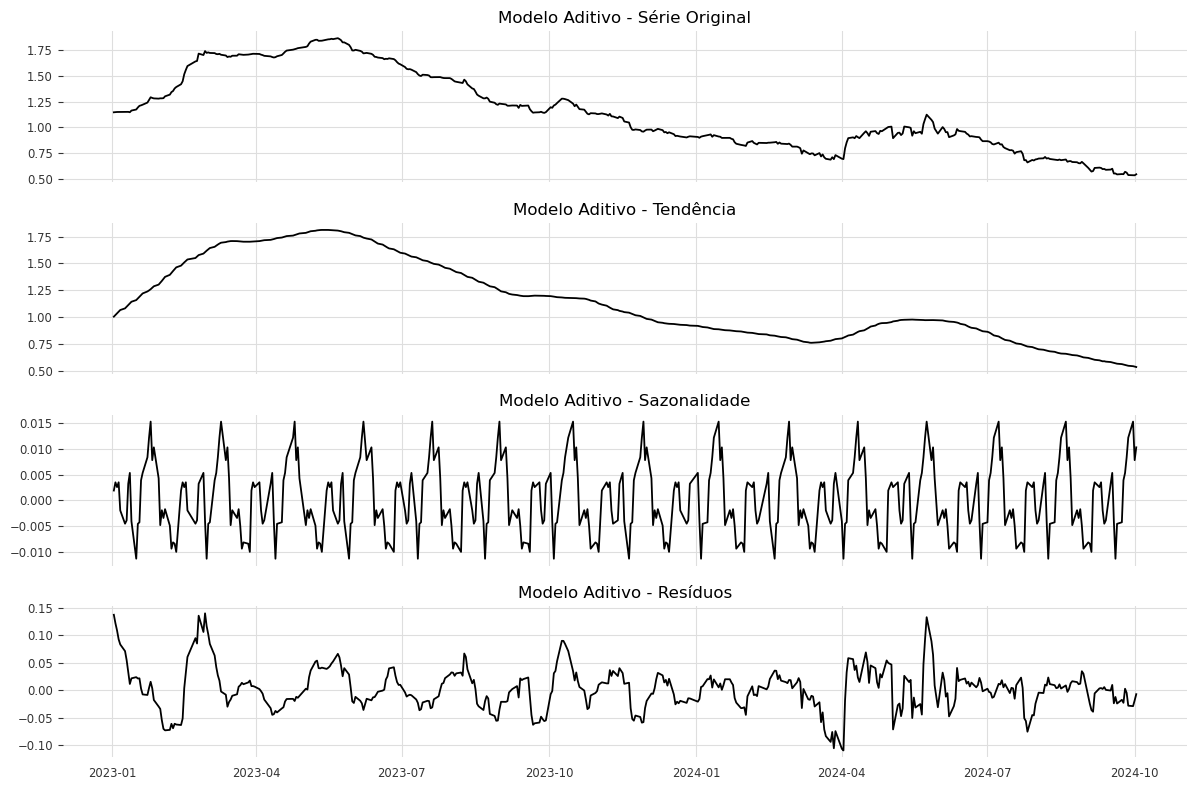

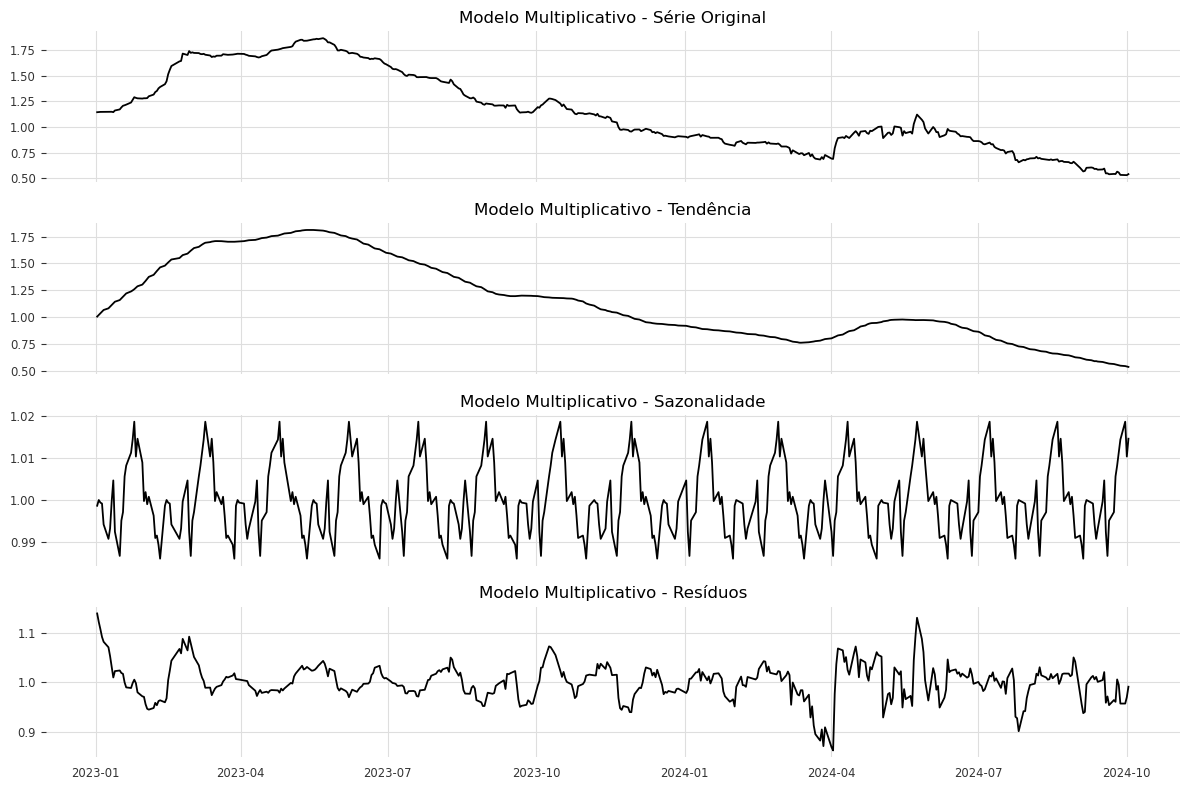

In [33]:
# ============================================
# Decomposição Aditiva e Multiplicativa
# ============================================
# Decomposição aditiva
result_add = seasonal_decompose(df_valid['taxaIndicativa'], model='additive', period=30, extrapolate_trend='freq')

# Decomposição multiplicativa
result_mult = seasonal_decompose(df_valid['taxaIndicativa'], model='multiplicative', period=30, extrapolate_trend='freq')

# Plotar a decomposição aditiva
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
axes[0].plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Original')
axes[0].set_title('Modelo Aditivo - Série Original')
axes[1].plot(df_valid['dataReferencia'], result_add.trend, label='Tendência')
axes[1].set_title('Modelo Aditivo - Tendência')
axes[2].plot(df_valid['dataReferencia'], result_add.seasonal, label='Sazonalidade')
axes[2].set_title('Modelo Aditivo - Sazonalidade')
axes[3].plot(df_valid['dataReferencia'], result_add.resid, label='Resíduos')
axes[3].set_title('Modelo Aditivo - Resíduos')
plt.tight_layout()
plt.show()

# Plotar a decomposição multiplicativa
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
axes[0].plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Original')
axes[0].set_title('Modelo Multiplicativo - Série Original')
axes[1].plot(df_valid['dataReferencia'], result_mult.trend, label='Tendência')
axes[1].set_title('Modelo Multiplicativo - Tendência')
axes[2].plot(df_valid['dataReferencia'], result_mult.seasonal, label='Sazonalidade')
axes[2].set_title('Modelo Multiplicativo - Sazonalidade')
axes[3].plot(df_valid['dataReferencia'], result_mult.resid, label='Resíduos')
axes[3].set_title('Modelo Multiplicativo - Resíduos')
plt.tight_layout()
plt.show()


c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


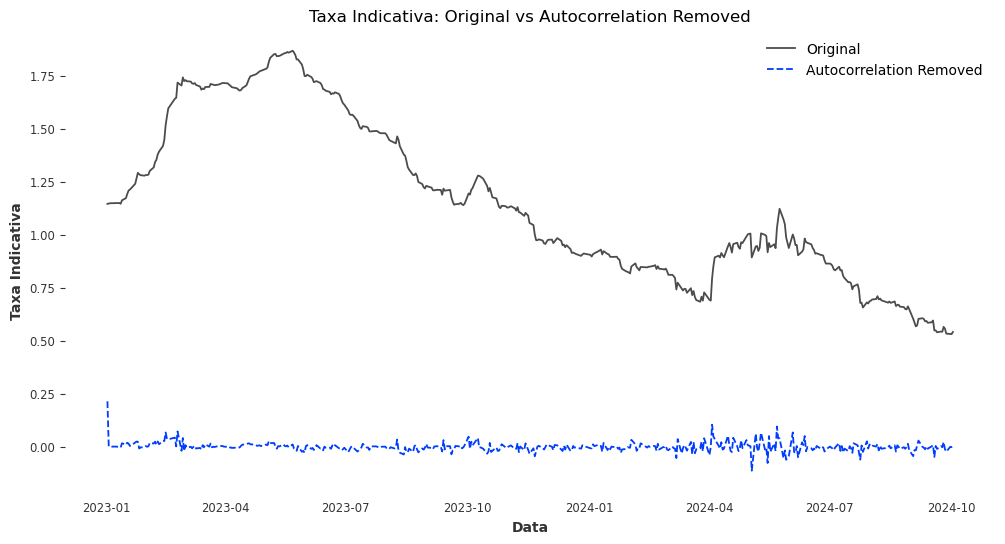

In [34]:
# ============================================
# Remoção da Autocorrelação com ARIMA
# ============================================
# Ajustar modelo ARIMA simples
model = ARIMA(df_valid['taxaIndicativa'], order=(1, 0, 1))
model_fit = model.fit()

# Resíduos sem autocorrelação
df_valid['taxaIndicativa_no_autocorr'] = model_fit.resid

# Plotar série original e resíduos sem autocorrelação
plt.figure(figsize=(12, 6))
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Original', alpha=0.7)
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa_no_autocorr'], label='Autocorrelation Removed', linestyle='--')
plt.title('Taxa Indicativa: Original vs Autocorrelation Removed')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


R² da tendência quadrática: 0.7449


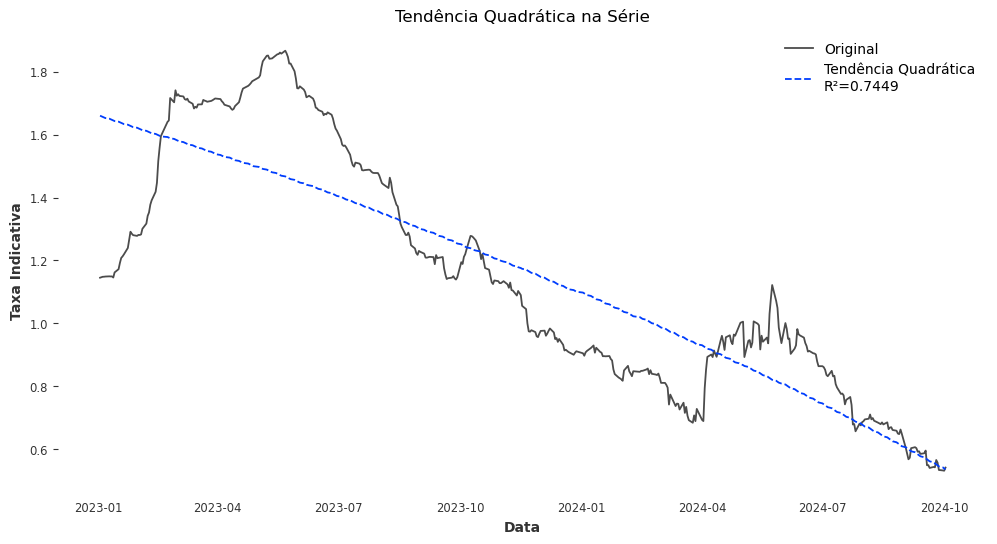

In [35]:
# ============================================
# Teste de Tendência Quadrática
# ============================================
# Ajustar modelo polinomial de grau 2
x = np.arange(len(df_valid))
y = df_valid['taxaIndicativa'].values
model_quadratic = Polynomial.fit(x, y, deg=2)
y_pred_quadratic = model_quadratic(x)

# R² para tendência quadrática
ss_total = np.sum((y - np.mean(y))**2)
ss_residual = np.sum((y - y_pred_quadratic)**2)
r_squared_quadratic = 1 - (ss_residual / ss_total)
print(f"R² da tendência quadrática: {r_squared_quadratic:.4f}")

# Plotar a tendência quadrática
plt.figure(figsize=(12, 6))
plt.plot(df_valid['dataReferencia'], y, label='Original', alpha=0.7)
plt.plot(df_valid['dataReferencia'], y_pred_quadratic, label=f'Tendência Quadrática\nR²={r_squared_quadratic:.4f}', linestyle='--')
plt.title('Tendência Quadrática na Série')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


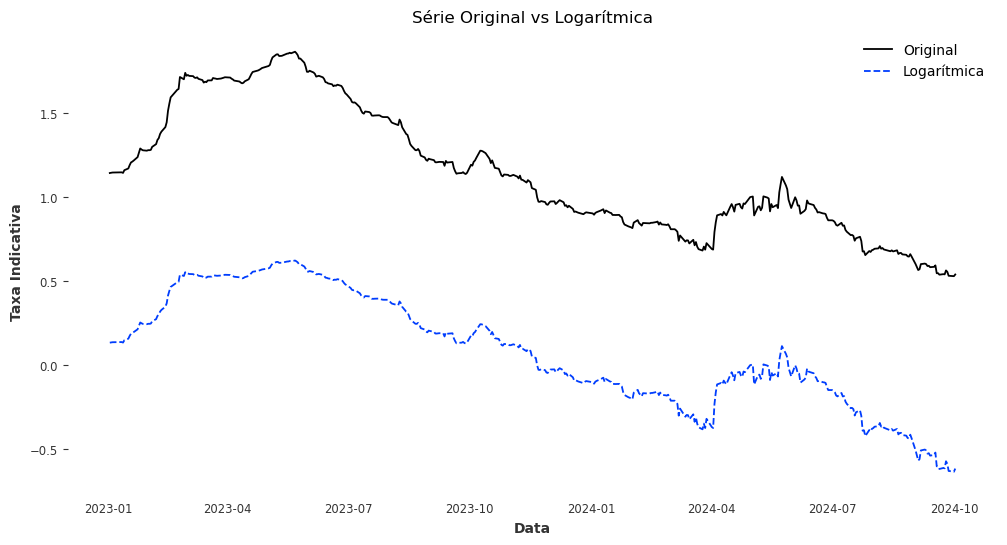

In [36]:

# ============================================
# Transformação Logarítmica
# ============================================
df_valid['taxaIndicativa_log'] = np.log(df_valid['taxaIndicativa'])
plt.figure(figsize=(12, 6))
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Original')
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa_log'], label='Logarítmica', linestyle='--')
plt.title('Série Original vs Logarítmica')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


In [37]:

# ============================================
# Diferenciação para Tornar a Série Estacionária
# ============================================
# Aplicar diferenciação
df_valid['taxaIndicativa_diff'] = df_valid['taxaIndicativa'].diff().dropna()

# Teste ADF na série diferenciada
adf_result_diff = adfuller(df_valid['taxaIndicativa_diff'].dropna())
print("\nTeste ADF na Série Diferenciada:")
print(f"ADF Estatística: {adf_result_diff[0]}")
print(f"p-valor: {adf_result_diff[1]}")
print("Valores críticos:", adf_result_diff[4])
if adf_result_diff[1] < 0.05:
    print("A série diferenciada é estacionária.")
else:
    print("A série diferenciada não é estacionária.")


Teste ADF na Série Diferenciada:
ADF Estatística: -5.242640939215781
p-valor: 7.190572913193051e-06
Valores críticos: {'1%': -3.445613745346461, '5%': -2.868269325317112, '10%': -2.5703544951308404}
A série diferenciada é estacionária.


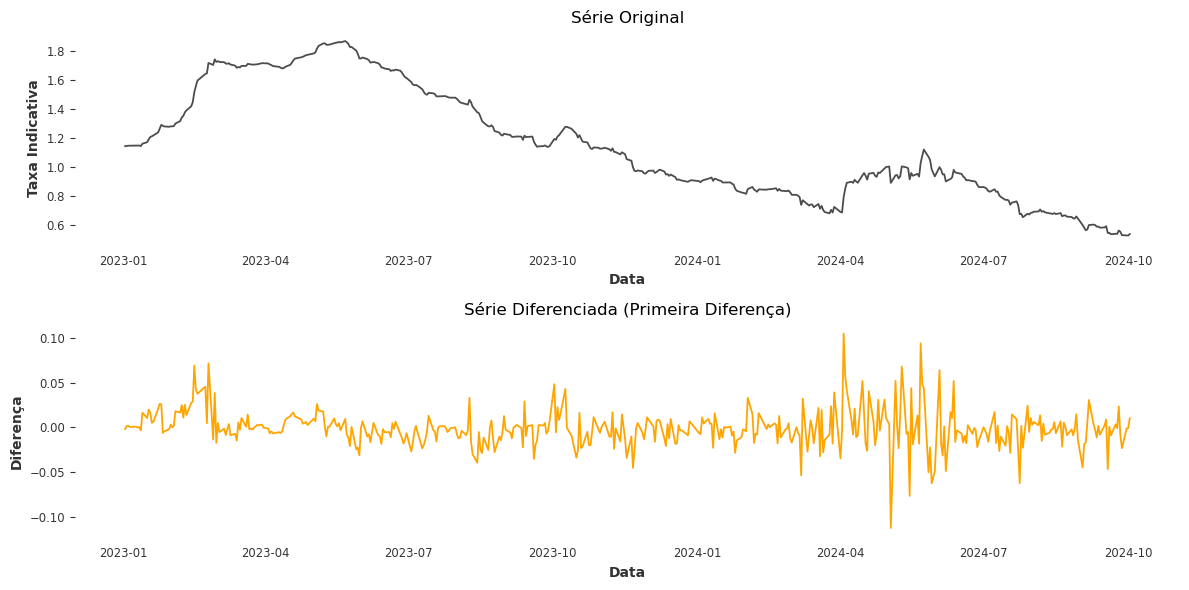

In [38]:
# Ajustar o Df para o data_valid
df_valid = df

# Ajustar o desalinhamento de índices após a diferenciação
df_valid_diff = df_valid.dropna(subset=['taxaIndicativa_diff'])

# Plotar novamente com correção
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Série Original', alpha=0.7)
plt.title('Série Original')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(df_valid_diff['dataReferencia'], df_valid_diff['taxaIndicativa_diff'], label='Série Diferenciada', color='orange')
plt.title('Série Diferenciada (Primeira Diferença)')
plt.xlabel('Data')
plt.ylabel('Diferença')
plt.grid()

plt.tight_layout()
plt.show()



### Realizar a ACF e PACF da variável taxaIndicativa_diff



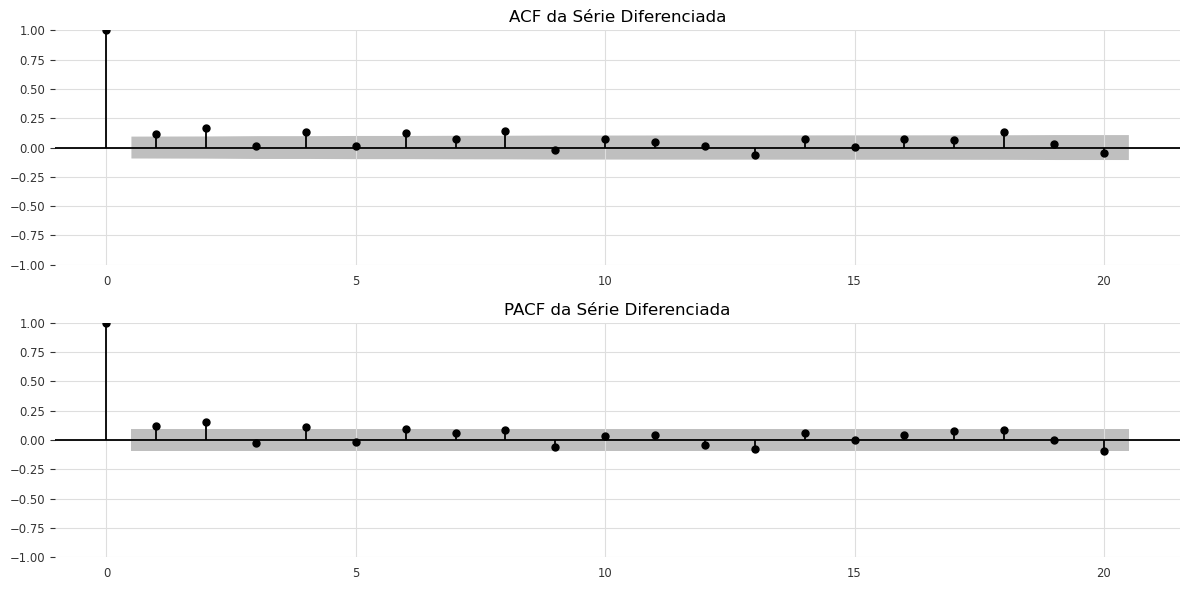

In [39]:
# Visualizar ACF e PACF para identificar os parâmetros (p, d, q)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(df_valid['taxaIndicativa_diff'].dropna(), lags=20, ax=plt.gca(), title='ACF da Série Diferenciada')
plt.subplot(2, 1, 2)
plot_pacf(df_valid['taxaIndicativa_diff'].dropna(), lags=20, ax=plt.gca(), title='PACF da Série Diferenciada')
plt.tight_layout()
plt.show()

## Realizar a previsao da série temporal utilizando o Auto ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2152.809, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2157.170, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2155.571, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-2166.591, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-2164.792, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-2169.367, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2168.978, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-2162.906, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2162.579, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-2174.645, Time=0.15 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-2172.839, Time=0.41 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-2171.955, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-2173.350, Time=0.46 sec
 ARIMA(4,0,1)(0,0,0)[0]  

c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


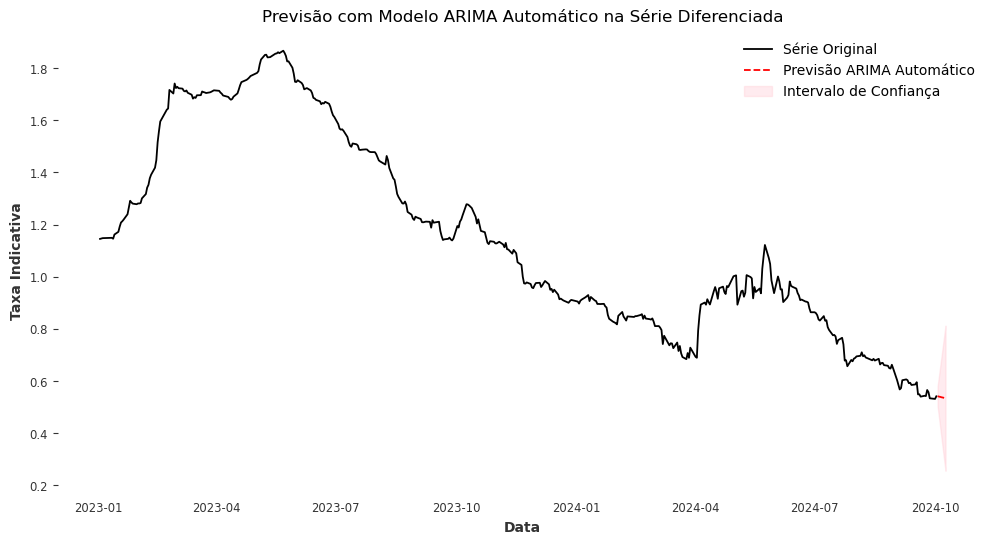

In [40]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Carregar o dataset
file_path = "ALGA28_2324.csv"
df = pd.read_csv(file_path)
df['dataReferencia'] = pd.to_datetime(df['dataReferencia'], errors='coerce')

# Preparar os dados e calcular a diferenciação
df_valid = df[['dataReferencia', 'taxaIndicativa']].dropna()
df_valid['taxaIndicativa_diff'] = df_valid['taxaIndicativa'].diff().dropna()

# Ajustar o modelo ARIMA automaticamente usando auto_arima na série diferenciada
stepwise_model = auto_arima(df_valid['taxaIndicativa_diff'].dropna(),
                            start_p=0, start_q=0,       # Valores iniciais de p e q
                            max_p=5, max_q=5,           # Valores máximos de p e q
                            d=0,                        # Série já diferenciada
                            seasonal=False,            # Sem sazonalidade
                            trace=True,                # Mostra os detalhes da busca
                            error_action='ignore',     # Ignora erros durante a busca
                            suppress_warnings=True,    # Suprime warnings
                            stepwise=True)             # Busca em modo stepwise

# Exibir o modelo selecionado
print(stepwise_model.summary())

# Fazer previsões para os próximos 7 períodos
n_periods = 7
forecast_diff, conf_int_diff = stepwise_model.predict(n_periods=n_periods, return_conf_int=True)

# Reintegrar as previsões para retornar à escala original
forecast_original = np.cumsum(forecast_diff) + df_valid['taxaIndicativa'].iloc[-1]

# Criar datas futuras para a previsão
forecast_dates = pd.date_range(df_valid['dataReferencia'].iloc[-1], periods=n_periods + 1, freq='D')[1:]

# Plotar a série original e as previsões
plt.figure(figsize=(12, 6))
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Série Original')
plt.plot(forecast_dates, forecast_original, label='Previsão ARIMA Automático', color='red', linestyle='--')
plt.fill_between(forecast_dates, 
                 np.cumsum(conf_int_diff[:, 0]) + df_valid['taxaIndicativa'].iloc[-1],
                 np.cumsum(conf_int_diff[:, 1]) + df_valid['taxaIndicativa'].iloc[-1],
                 color='pink', alpha=0.3, label="Intervalo de Confiança")
plt.title('Previsão com Modelo ARIMA Automático na Série Diferenciada')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()



## Encontrado que o modelo que melhor se adapta é o SARIMAX (3,0,2)

c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         taxaIndicativa   No. Observations:                  440
Model:               SARIMAX(3, 0, 2)   Log Likelihood                1073.356
Date:                Wed, 11 Dec 2024   AIC                          -2134.712
Time:                        15:51:27   BIC                          -2110.191
Sample:                             0   HQIC                         -2125.038
                                - 440                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9740      0.007   -138.376      0.000      -0.988      -0.960
ar.L2          0.9822      0.004    279.212      0.000       0.975       0.989
ar.L3          0.9918      0.006    177.405      0.0

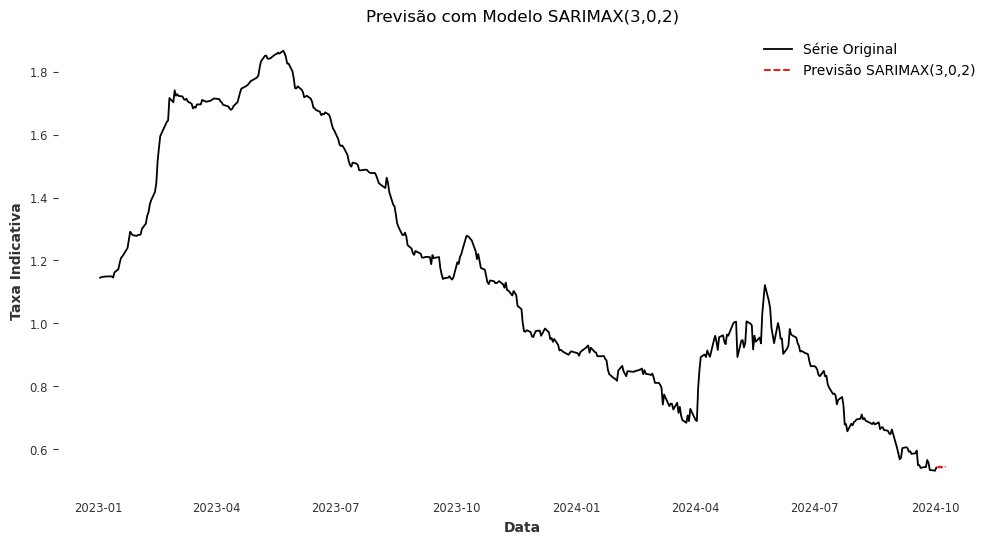

In [41]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Carregar o dataset
file_path = "ALGA28_2324.csv"
df = pd.read_csv(file_path)
df['dataReferencia'] = pd.to_datetime(df['dataReferencia'], errors='coerce')

# Preparar os dados
df_valid = df[['dataReferencia', 'taxaIndicativa']].dropna()

# Ajustar o modelo SARIMAX(5,0,0)
model_sarimax = SARIMAX(df_valid['taxaIndicativa'], order=(3, 0, 2), seasonal_order=(0, 0, 0, 0))
model_fit = model_sarimax.fit()

# Exibir o resumo do modelo
print(model_fit.summary())

# Fazer previsões para os próximos 7 períodos
n_periods = 7
forecast = model_fit.forecast(steps=n_periods)

# Criar datas futuras para a previsão
forecast_dates = pd.date_range(df_valid['dataReferencia'].iloc[-1], periods=n_periods + 1, freq='D')[1:]

# Plotar a série original e as previsões
plt.figure(figsize=(12, 6))
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Série Original')
plt.plot(forecast_dates, forecast, label='Previsão SARIMAX(3,0,2)', color='red', linestyle='--')
plt.title('Previsão com Modelo SARIMAX(3,0,2)')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


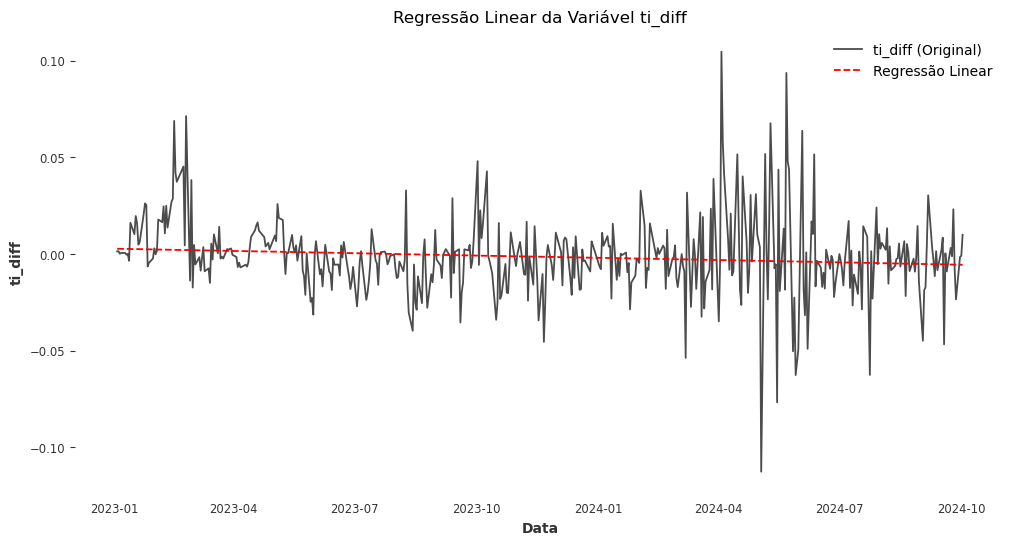

(-1.8977141527926316e-05, 0.002780367570925658, 0.01343689293887651)

In [42]:
# Recarregar bibliotecas e dados após reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Carregar o dataset
file_path = "ALGA28_2324.csv"
df = pd.read_csv(file_path)
df['dataReferencia'] = pd.to_datetime(df['dataReferencia'], errors='coerce')
# Renomear a coluna 'taxaIndicativa_diff' para 'ti_diff'
df_valid = df_valid.rename(columns={'taxaIndicativa_diff': 'ti_diff'})

# Preparação da variável
df['dataReferencia'] = pd.to_datetime(df['dataReferencia'], errors='coerce')
df_valid = df[['dataReferencia', 'taxaIndicativa']].dropna()
df_valid['ti_diff'] = df_valid['taxaIndicativa'].diff()

# Remover valores nulos da variável ti_diff
df_valid = df_valid.dropna(subset=['ti_diff'])

# Preparar dados para regressão
x = np.arange(len(df_valid)).reshape(-1, 1)  # Variável independente: tempo
y = df_valid['ti_diff'].values.reshape(-1, 1)  # Variável dependente: ti_diff

# Ajustar o modelo de regressão linear
model = LinearRegression()
model.fit(x, y)

# Prever os valores ajustados
y_pred = model.predict(x)

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_valid['dataReferencia'], y, label='ti_diff (Original)', alpha=0.7)
plt.plot(df_valid['dataReferencia'], y_pred, label='Regressão Linear', color='red', linestyle='--')
plt.title('Regressão Linear da Variável ti_diff')
plt.xlabel('Data')
plt.ylabel('ti_diff')
plt.legend()
plt.grid()
plt.show()

# Coeficientes da regressão
slope = model.coef_[0][0]
intercept = model.intercept_[0]
r_squared = model.score(x, y)

slope, intercept, r_squared


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2152.809, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2157.170, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2155.571, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-2166.591, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-2164.792, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-2169.367, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2168.978, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-2162.906, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2162.579, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-2174.645, Time=0.16 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-2172.839, Time=0.43 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-2171.955, Time=0.35 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-2173.350, Time=0.47 sec
 ARIMA(4,0,1)(0,0,0)[0]  

c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


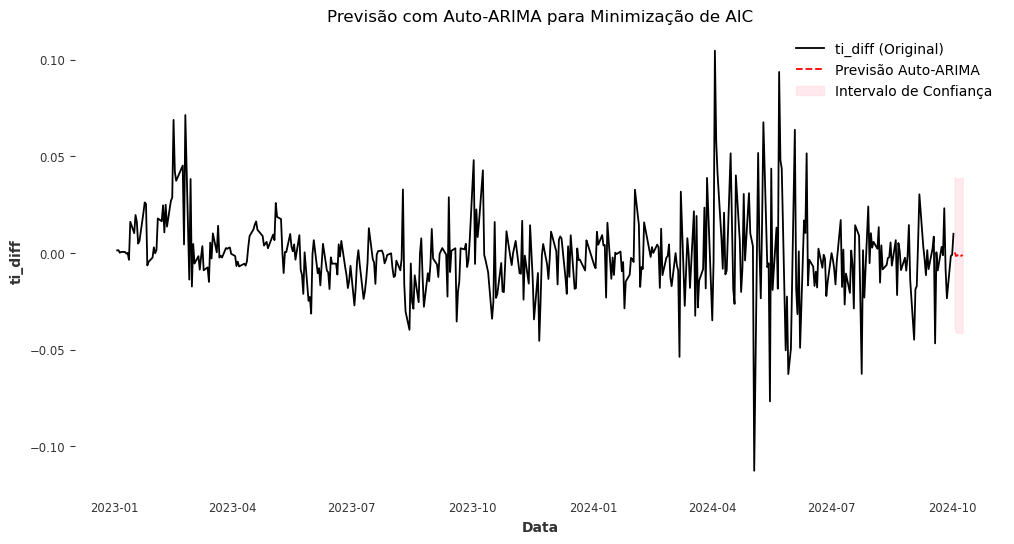

In [43]:
from pmdarima import auto_arima
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o dataset
file_path = "ALGA28_2324.csv"
df = pd.read_csv(file_path)
df['dataReferencia'] = pd.to_datetime(df['dataReferencia'], errors='coerce')

# Preparar a variável diferenciada
df['ti_diff'] = df['taxaIndicativa'].diff().dropna()

# Aplicar auto_arima para minimizar o AIC
auto_model = auto_arima(
    df['ti_diff'].dropna(),
    start_p=0, start_q=0,     
    max_p=5, max_q=5,         
    d=0,                      
    seasonal=False,           
    trace=True,               
    error_action='ignore',    
    suppress_warnings=True,   
    stepwise=True             
)

# Exibir o resumo do modelo e o melhor AIC encontrado
print(auto_model.summary())
print(f"Melhor AIC: {auto_model.aic()}")

# Previsão futura
n_periods = 7
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Criar datas para a previsão
forecast_dates = pd.date_range(df['dataReferencia'].dropna().iloc[-1], periods=n_periods + 1, freq='D')[1:]

# Plotar previsões
plt.figure(figsize=(12, 6))
plt.plot(df['dataReferencia'], df['ti_diff'], label='ti_diff (Original)')
plt.plot(forecast_dates, forecast, label='Previsão Auto-ARIMA', color='red', linestyle='--')
plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Intervalo de Confiança')
plt.title('Previsão com Auto-ARIMA para Minimização de AIC')
plt.xlabel('Data')
plt.ylabel('ti_diff')
plt.legend()
plt.grid()
plt.show()


In [48]:
# Converter a coluna 'dataReferencia' para datetime
df['dataReferencia'] = pd.to_datetime(df['dataReferencia'], errors='coerce')

# Criar uma nova coluna 'AnoMes' para agrupar por ano e mês
df['AnoMes'] = df['dataReferencia'].dt.to_period('M')

# Criar um diretório para salvar as séries mensais
output_dir = "series_mensais"
os.makedirs(output_dir, exist_ok=True)

# Iterar pelos meses únicos e salvar cada subconjunto em um arquivo CSV
for period, group in df.groupby('AnoMes'):
    output_file = os.path.join(output_dir, f"ALGA_MBM_{period}.csv")
    group.to_csv(output_file, index=False)
    print(f"Série mensal salva: {output_file}")


Série mensal salva: series_mensais\ALGA_MBM_2023-01.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-02.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-03.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-04.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-05.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-06.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-07.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-08.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-09.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-10.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-11.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-12.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-01.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-02.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-03.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-04.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-05.csv
Série mensal salva: series_mensais\ALGA_MBM_2024

In [1]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


#
# Filtrar apenas a série diferenciada (ignorar o primeiro valor NaN da diferenciação)
df_diff = df.dropna(subset=['taxaIndicativa_diff']).reset_index(drop=True)

# Dividir os dados: treino (22 primeiros dias) e teste (7 dias seguintes)
train = df_diff.iloc[:59]
test = df_diff.iloc[59:66]

# Treinar o modelo ARIMA
model = ARIMA(train['taxaIndicativa_diff'], order=(3, 0, 2))  # Ordem ARIMA pode ser ajustada
model_fit = model.fit()

# Fazer previsões para os próximos 7 dias
forecast = model_fit.forecast(steps=len(test))

# Reintegrar a série diferenciada para compará-la com os valores reais
# Somar os valores previstos cumulativamente ao último valor da série original de treino
forecast_reintegrated = np.cumsum(forecast) + train['taxaIndicativa'].iloc[-1]

# Preparar os valores reais da série original
real_values = test['taxaIndicativa']

# Criar datas para as previsões
forecast_dates = test['dataReferencia']

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df['dataReferencia'], df['taxaIndicativa'], label='Valores Reais', alpha=0.6)
plt.plot(forecast_dates, forecast_reintegrated, label='Previsões ARIMA (7 dias)', color='red', linestyle='--')
plt.title('Previsão ARIMA para os Últimos 7 Dias')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()

# Exibir previsões e valores reais
forecast_results = pd.DataFrame({
    'Data': forecast_dates,
    'Valores Reais': real_values.values,
    'Previsões': forecast_reintegrated.values
})
print(forecast_results)


NameError: name 'df' is not defined

### Rodar uma analise de correlacao entre as variaveis dentro do titulo ALGA28

# Professor Michel
#### Aplicar todas as diferenciaoes possiveis (ao menos 3) e verificar qual apresenta uma estacionaridade melhor

+ Remover a tendencia
+ Remover a sazonalidade
+ Remover a autocorrelacao
+ colocarr a base logaritmica (Se tiver uma tendencia exponencial)
+ Aplicar a transformacao de raiz quadrada (Se tiver uma tendencia quadratica)
+ Dado essa serie aplique Dick Fuller, e trace a media da curva.
+ Fica de olho no resultado do P valor do teste em relacao a cada um dos modelos acima.

#### Passo 2 => Olhar visualmente e pelo teste cada uma das series e na sequencia aplicar o modelo preditivo quais(todos ensinados pela Paloma), 
### aplicar a regressao classica na serie mais estacionaria.

# Heitor
+ Dentro da série diferenciada. Realizar uma distribuição num histograma de grequencia para verificar se a distribuição é normal.
+ Fazer  o previsto contra o realizado pra diversas datas.
+ Varios gráficos de 22 dias
+ Retirar os dados antes de 2023


In [44]:
#Aplicar todas as diferenciaoes possiveis (ao menos 3) e verificar qual apresenta uma estacionaridade melhor

#Remover a tendencia
#Remover a sazonalidade
#Remover a autocorrelacao
#colocarr a base logaritmica (Se tiver uma tendencia exponencial)
#Aplicar a transformacao de raiz quadrada (Se tiver uma tendencia quadratica)
#Dado essa serie aplique Dick Fuller, e trace a media da curva.
#Fica de olho no resultado do P valor do teste em relacao a cada um dos modelos acima.

#Passo 2 => Olhar visualmente e pelo teste cada uma das series e na sequencia aplicar o modelo preditivo quais(todos ensinados pela Paloma), 
# aplicar a regressao classica na serie mais estacionaria.

In [45]:
#remover a tendencia da variavel temporal taxaIndicativa
